In [53]:
from scipy.sparse import coo_matrix
import bioframe as bf
import bioframe.vis
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
%matplotlib inline

from collections import Counter
import itertools
import sys
from collections import OrderedDict
import random
import seaborn as sns
import scipy
import pickle


# post-processing: filtering

In [54]:
##nf-core atac pipeline was used in default mode to generate paired end bams.  
##Downstream analysis and QC were done using ful reads (centres)
##first I will call peaks using SE read ends of either full reads or reads <= 120bp for different analyses


In [55]:
#1. filter mapq30, dups, reduced chroms


In [56]:
# PCR dups,mapq30,keep paired
# bam='/mG_REP1.mLb.clN.sorted.bam'
# out='/mG_REP1.sorted.nodups.mapq30.t2.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools view -f 0x2 -q 30 -b -h -F 1024 $bam > $out"
    

In [57]:
#sort (if done in separate steps)

# bam='/mG_REP1.sorted.nodups.mapq30.t2.bam'
# out='/mG_REP1.sorted.nodups.mapq30.t2.sorted.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools sort $bam > $out"
    

In [58]:
#index
# bam='/mG_REP1.sorted.nodups.mapq30.t2.sorted.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools index $bam"
    

In [59]:
#keep only chroms (no M)

# bam='mG_REP1.sorted.nodups.mapq30.t2.sorted.bam'
# out='/mG_REP1.sorted.nodups.mapq30.t2.sorted.reducedchroms.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools view -h $bam chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 > $out"


In [60]:
#sort again

# bam='/mG_REP1.sorted.nodups.mapq30.t2.sorted.reducedchroms.bam'
# out='/mG_REP1.nodups.mapq30.t2.sorted.reducedchroms.sorted.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools sort $bam > $out"


In [61]:
#index again

# bam='/mG_REP1.nodups.mapq30.t2.sorted.reducedchroms.sorted.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools index $bam"
    

# <120bp reads (can center for peak calling)


In [62]:
#if desired keep only < 120bp frags

# bam='/mG_REP1.nodups.mapq30.t2.sorted.reducedchroms.sorted.bam'
# out='/mG_REP1.nodups.mapq30.t2.sorted.reducedchroms.sorted.FL120.bam'
# !samtools view -h $bam | awk 'substr($0,1,1)=="@" || ($9>= 0 && $9<=120) || ($9<=0 && $9>=-120)' | samtools view -b > $out


In [63]:
#sort again

# bam='/mG_REP1.nodups.mapq30.t2.sorted.reducedchroms.sorted.FL120.bam'
# out='mG_REP1.nodups.mapq30.t2.sorted.reducedchroms.sorted.FL120.sorted.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools sort $bam > $out"
    

In [64]:
#index again

# bam='/mG_REP1.nodups.mapq30.t2.sorted.reducedchroms.sorted.FL120.sorted.bam'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools index $bam"
    

# single end bed for peak calling: keep ends

In [65]:
#make single end bed. the samtoolsflags uneccessary given the above filtering steps

# bam='/pM_REP2.nodups.mapq30.t2.sorted.reducedchroms.sorted.bam'
# out='/pM_REP2.reducedchroms.sorted.bed'
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "samtools view -bf 0x2 $bam | bedtools bamtobed -i stdin >| $out"


# shift reads for tn5

In [66]:

#!cat /Mp.reducedchroms.sorted.bed | awk -F $'\t' 'BEGIN {OFS = FS}{ if ($6 == "+") {$2= $2 + 4} else if ($6 == "-") {$3 = $3 - 5} print $0}' >| /Mp.reducedchroms.sorted.p4m5.bed

##for coverage, keep only end, so make 2nd step:
#!cat /Mp.reducedchroms.sorted.p4m5.bed | awk -F $'\t' 'BEGIN {OFS = FS}{ if ($6 == "+") {$2= $2-1;$3 = $2 + 2;} else if ($6 == "-") {$3 = $3 + 1;$2 = $3 - 2;} print $0}' >| Mp.reducedchroms.sorted.p4m5_ends.bed



# make pooled mitotic set

In [67]:
#sort -k1,1 -k2,2n mM_R1.reducedchroms.sorted.p4m5.bed pM_R1.reducedchroms.sorted.p4m5.bed > MR1.reducedchroms.sorted.p4m5.bed
#sort -k1,1 -k2,2n mM_R2.reducedchroms.sorted.p4m5.bed pM_R2.reducedchroms.sorted.p4m5.bed > MR2.reducedchroms.sorted.p4m5.bed
#sort -k1,1 -k2,2n mMp.reducedchroms.sorted.p4m5.sorted.bed pMp.reducedchroms.sorted.p4m5.sorted.bed > Mp.reducedchroms.sorted.p4m5.sorted.bed


# make bigwigs scaled to 10E6 reads


In [68]:
  # 191456639 pG_REP1.reducedchroms.sorted.p4m5.ends.bed 0.05223114775351301
  # 146370798 pG_REP2.reducedchroms.sorted.p4m5.ends.bed 0.06831963845684574
  # 200086671 pM_REP1.reducedchroms.sorted.p4m5.ends.bed 0.04997834163576043
  # 117654257 pM_REP2.reducedchroms.sorted.p4m5.ends.bed 0.0849947996356817
  # 184887917 mG_REP1.reducedchroms.sorted.p4m5.ends.bed 0.054086822774903134
  # 163581501 mG_REP2.reducedchroms.sorted.p4m5.ends.bed 0.06113160680681124
  # 147253247 mM_REP1.reducedchroms.sorted.p4m5.ends.bed 0.06791021728709316
  # 151592262 mM_REP2.reducedchroms.sorted.p4m5.ends.bed 0.06596642775869391


In [69]:
#genomecov bed

# bed='/mM_REP2.reducedchroms.sorted.p4m5.ends.bed'
# chroms='/hg38.reduced.chrom.sizes'
# out='/mM_REP2.genomcov.scaled.bed'
# !bsub -q short -W 04:00 -n 2 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "bedtools genomecov -bg -scale 0.06596642775869391 -i $bed -g $chroms > $out" 


In [70]:
#sort genomecov bed

# bed1='/mM_REP2.genomcov.scaled.bed'
# out='/mM_REP2.genomcov.scaled.sorted.bed'
# !bsub -q short -W 04:00 -n 2 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#         "sort -k1,1 -k2,2n $bed1 > $out"


In [71]:
#bedGraphToBigWig myFile_sorted.bedgraph myChrom.sizes myBigWig.bw



# fragment length distributions

In [72]:
#ie
# bam='pGp.nodups.mapq30.t2.sorted.reducedchroms.sorted.bam' 
# out='/fld/pGp' 
# !bsub -q short -W 08:00 -n 4 -R "span[hosts=1]" -R "rusage[mem=8000]" \
#     "bamPEFragmentSize --bamfiles --out $out"


In [73]:
mm3=pd.read_csv('/home/allana.schooley-umw/as38w/Ranger/atac/nfatac_wbl_R1R3/result/filtered/fld/mMp', sep='\t', skiprows=1)
mm3['frac']=(mm3['Occurrences']/mm3['Occurrences'].sum()).astype('float64')
pm3=pd.read_csv('/home/allana.schooley-umw/as38w/Ranger/atac/nfatac_wbl_R1R3/result/filtered/fld/pMp', sep='\t', skiprows=1)
pm3['frac']=(pm3['Occurrences']/pm3['Occurrences'].sum()).astype('float64')
mg3=pd.read_csv('/home/allana.schooley-umw/as38w/Ranger/atac/nfatac_wbl_R1R3/result/filtered/fld/mGp', sep='\t', skiprows=1)
mg3['frac']=(mg3['Occurrences']/mg3['Occurrences'].sum()).astype('float64')
pg3=pd.read_csv('/home/allana.schooley-umw/as38w/Ranger/atac/nfatac_wbl_R1R3/result/filtered/fld/pGp', sep='\t', skiprows=1)
pg3['frac']=(pg3['Occurrences']/pg3['Occurrences'].sum()).astype('float64')

mp=pd.concat([mm3,pm3])

mp


,Size,Occurrences,Sample,frac
0,26,21,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000137
1,27,40,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000261
2,28,49,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000319
3,29,57,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000371
4,30,47,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000306
...,...,...,...,...
1088,1143,2,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000012
1089,1149,1,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000006
1090,1153,1,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000006
1091,1154,1,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000006


In [51]:
#to bin in5bp intervals
#bins = np.linspace(0, 1000, 201)
#skip zero bins since reads > 25bp only were kept
bins = np.linspace(25, 1015, 199)

#mm3_tocut=mm3[(mm3['Size']<=1000)]
cut1=pd.cut(mm3['Size'], bins)
#mg3_tocut=mg3[(mg3['Size']<=1000)]
cut2=pd.cut(mg3['Size'], bins)
#pg3_tocut=pg3[(pg3['Size']<=1000)]
cut3=pd.cut(pg3['Size'], bins)
cut4=pd.cut(mp['Size'],bins)

df1=mm3
s1=df1.groupby(cut1).agg({'Occurrences':'sum','frac':'sum'})
#s1.E=s1.index.map(lambda x :x.left)
s1.reset_index(drop=True,inplace=True)
s1['newfrac']=(s1['Occurrences']/mm3['Occurrences'].sum())/5

df2=mg3
s2=df2.groupby(cut2).agg({'Occurrences':'sum','frac':'sum'})
#s2.E=s2.index.map(lambda x :x.left)
s2.reset_index(drop=True,inplace=True)
s2['newfrac']=(s2['Occurrences']/mg3['Occurrences'].sum())/5

df3=pg3
s3=df3.groupby(cut3).agg({'Occurrences':'sum','frac':'sum'})
#s3.E=s3.index.map(lambda x :x.left)
s3.reset_index(drop=True,inplace=True)
s3['newfrac']=(s3['Occurrences']/pg3['Occurrences'].sum())/5

df4=mp
s4=df4.groupby(cut4).agg({'Occurrences':'sum','frac':'sum'})
#s3.E=s3.index.map(lambda x :x.left)
s4.reset_index(drop=True,inplace=True)
s4['newfrac']=(s4['Occurrences']/mp['Occurrences'].sum())/5

mp

/tmp/ipykernel_56122/3163636929.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s1=df1.groupby(cut1).agg({'Occurrences':'sum','frac':'sum'})
/tmp/ipykernel_56122/3163636929.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s2=df2.groupby(cut2).agg({'Occurrences':'sum','frac':'sum'})
/tmp/ipykernel_56122/3163636929.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s3=df3.groupby(cut3).agg({'Occurrences':'sum','

,Size,Occurrences,Sample,frac
0,26,21,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000137
1,27,40,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000261
2,28,49,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000319
3,29,57,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000371
4,30,47,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000306
...,...,...,...,...
1088,1143,2,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000012
1089,1149,1,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000006
1090,1153,1,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000006
1091,1154,1,/home/allana.schooley-umw/as38w/Ranger/atac/nf...,0.000006


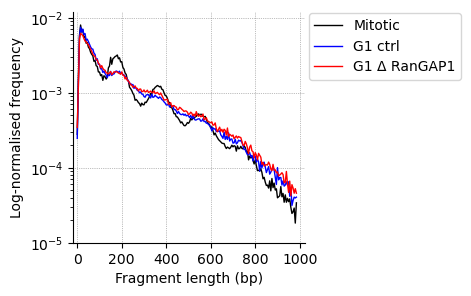

In [52]:
# plot binned data
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))


ax.plot(s4['newfrac'],lw=1,color='black',label='Mitotic')
ax.plot(s2['newfrac'],lw=1,color='blue', label='G1 ctrl')
ax.plot(s3['newfrac'],lw=1,color='red', label='G1 Δ RanGAP1')

ax.set_yscale('log')
ax.set_ylim(0.00001,0.012)
ax.set_xlim(-4,205)
ax.set_xticks([0,40,80,120,160,200])
ax.set_xticklabels([0,200,400,600,800,1000],visible=True)
ax.xaxis.set_ticks_position("bottom")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Log-normalised frequency')
ax.set_xlabel('Fragment length (bp)')
ax.grid(axis='x',color='grey', linewidth=0.5 , ls=':')
ax.grid(axis='y',color='grey', linewidth=0.5 , ls=':')

plt.legend()
ax.legend(bbox_to_anchor=(1.7, 1.025))

#plt.savefig('.pdf',dpi=300,bbox_inches='tight')
